In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("/content/loan_approval_dataset.csv")
df.columns = df.columns.str.strip()
df.drop('loan_id', axis=1, inplace=True)
print(df.columns)



Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


In [3]:
df['education'] = df['education'].str.strip()
df['self_employed'] = df['self_employed'].str.strip()
df['loan_status'] = df['loan_status'].str.strip()
df["education"]=df["education"].map({"Graduate":1,"Not Graduate":0})
df["self_employed"]=df["self_employed"].map({"Yes":1,"No":0})
df["loan_status"]=df["loan_status"].map({"Approved":1,"Rejected":0})
for column in df.columns:
  print(f"column : {column}  mean value :{df[column].mean()}")

column : no_of_dependents  mean value :2.4987116420707425
column : education  mean value :0.502225345514172
column : self_employed  mean value :0.5036308268915437
column : income_annum  mean value :5059123.9166081045
column : loan_amount  mean value :15133450.456781447
column : loan_term  mean value :10.900445069102835
column : cibil_score  mean value :599.9360505973295
column : residential_assets_value  mean value :7472616.537830873
column : commercial_assets_value  mean value :4973155.3056922
column : luxury_assets_value  mean value :15126305.926446475
column : bank_asset_value  mean value :4976692.433825252
column : loan_status  mean value :0.622159756383228


In [47]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']
numeric_features = [
    'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
    'cibil_score', 'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]
scaler=StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

print(X.head)
print(y.head)



<bound method NDFrame.head of       no_of_dependents  education  self_employed  income_annum  loan_amount  \
0            -0.294102          1              0      1.617979     1.633052   
1            -1.473548          0              1     -0.341750    -0.324414   
2             0.295621          1              0      1.439822     1.610933   
3             0.295621          1              0      1.119139     1.721525   
4             1.475067          0              1      1.689242     1.002681   
...                ...        ...            ...           ...          ...   
4264          1.475067          1              1     -1.446324    -1.419268   
4265         -1.473548          0              1     -0.626801    -0.423946   
4266         -0.294102          0              0      0.513405     0.969504   
4267         -0.883825          0              0     -0.341750    -0.258059   
4268         -0.883825          1              0      1.475453     1.610933   

      loan_term  cibi

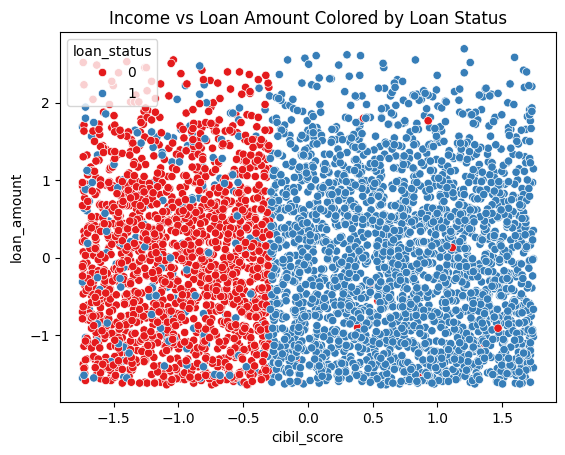

In [50]:
X_plot=X.copy()
X_plot["loan_status"]=y
sns.scatterplot(
    data=X_plot,
    x='cibil_score',
    y='loan_amount',
    hue='loan_status',  # Color by label
    palette='Set1'
)

plt.title('Income vs Loan Amount Colored by Loan Status')
plt.show()

In [53]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape)
print(X_test.shape)

(3415, 11)
(854, 11)


In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(X_train.shape)

(4250, 11)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve,f1_score

In [72]:
model1=LogisticRegression()
model2=RandomForestClassifier(n_estimators=100)
model3=XGBClassifier()
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=model2,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',  # or 'roc_auc', 'accuracy', etc.
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train[:1000],y_train[:1000])
best_param=grid_search.best_params_
print(best_param)
model2=grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [74]:
model2.fit(X_train,y_train)
def eval(model,X_test,y_test):
  y_pred=model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_prob)
  acc=accuracy_score(y_test,y_pred)

  print(f"Accuracy: {acc:.4f}")
  print(f"Precision     : {precision:.4f}")
  print(f"Recall        : {recall:.4f}")
  print(f"F1 Score      : {f1:.4f}")
  print(f"ROC AUC Score : {roc_auc:.4f}")

  fpr, tpr, _ = roc_curve(y_test, y_prob)

  plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
  plt.plot([0, 1], [0, 1], 'k--')  # random line
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

model : LogisticRegression()
Accuracy: 0.9227
Precision     : 0.9515
Recall        : 0.9228
F1 Score      : 0.9369
ROC AUC Score : 0.9733


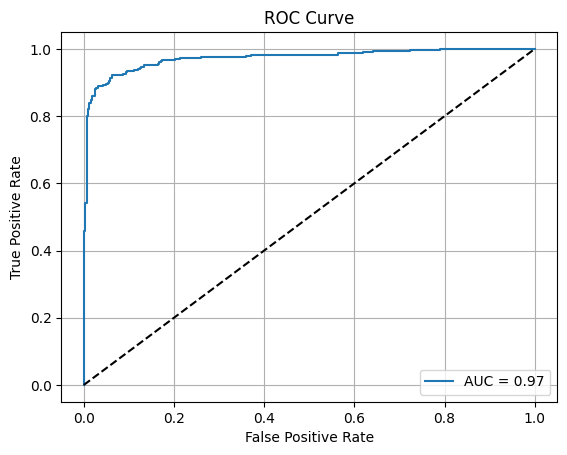

model : RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200)
Accuracy: 0.9824
Precision     : 0.9850
Recall        : 0.9868
F1 Score      : 0.9859
ROC AUC Score : 0.9989


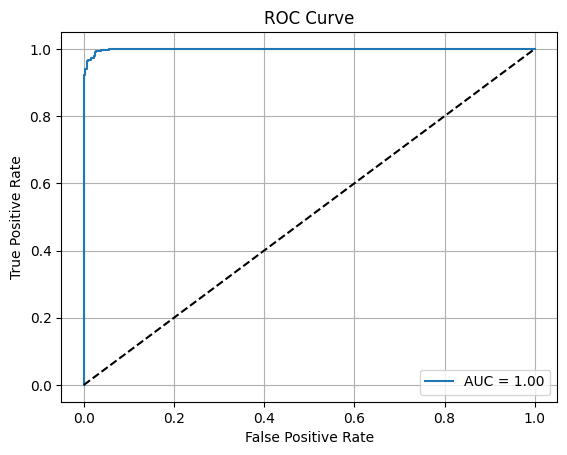

model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.9824
Precision     : 0.9850
Recall        : 0.9868
F1 Score      : 0.9859
ROC AUC Score : 0.9987


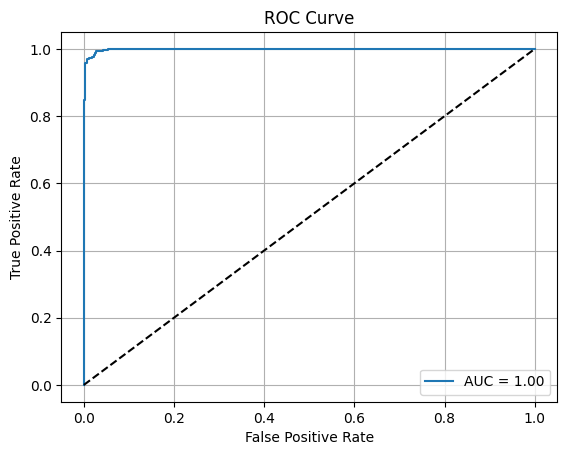

In [75]:
for model in [model1,model2,model3]:
  print(f"model : {model}")
  eval(model,X_test,y_test)

In [76]:
import joblib

joblib.dump(model2, 'rf_model.pkl')

joblib.dump(scaler, 'scaler.pkl')

joblib.dump(numeric_features, 'numeric_features.pkl')


['numeric_features.pkl']